In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Set a consistent style for our plots
sns.set_style('darkgrid')

In [3]:
netflix_df = pd.read_csv('netflix_titles.csv')
netflix_df.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,TV Show,3%,NaN,"João Miguel, Bianca Comparato, Michel Gomes, R...",Brazil,"August 14, 2020",2020,TV-MA,4 Seasons,"International TV Shows, TV Dramas, TV Sci-Fi &...",In a future where the elite inhabit an island ...
1,s2,Movie,7:19,Jorge Michel Grau,"Demián Bichir, Héctor Bonilla, Oscar Serrano, ...",Mexico,"December 23, 2016",2016,TV-MA,93 min,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...
2,s3,Movie,23:59,Gilbert Chan,"Tedd Chan, Stella Chung, Henley Hii, Lawrence ...",Singapore,"December 20, 2018",2011,R,78 min,"Horror Movies, International Movies","When an army recruit is found dead, his fellow..."
3,s4,Movie,9,Shane Acker,"Elijah Wood, John C. Reilly, Jennifer Connelly...",United States,"November 16, 2017",2009,PG-13,80 min,"Action & Adventure, Independent Movies, Sci-Fi...","In a postapocalyptic world, rag-doll robots hi..."
4,s5,Movie,21,Robert Luketic,"Jim Sturgess, Kevin Spacey, Kate Bosworth, Aar...",United States,"January 1, 2020",2008,PG-13,123 min,Dramas,A brilliant group of students become card-coun...


In [4]:
# 1. Handle missing values in 'director' and 'cast'
# Since these are text fields and many are missing, we'll fill them with 'Unknown'.
netflix_df['director'] = netflix_df['director'].fillna('Unknown')
netflix_df['cast'] = netflix_df['cast'].fillna('Unknown')

In [5]:
# 2. Handle missing 'country'
# We'll fill with the mode, which is the most common country.
mode_country = netflix_df['country'].mode()[0]
netflix_df['country'] = netflix_df['country'].fillna(mode_country)

In [6]:
# 3. Drop the few rows with missing 'date_added' and 'rating'
# Since the number is small (less than 0.2% of data), dropping them is a safe option.
netflix_df.dropna(subset=['date_added', 'rating'], inplace=True)

In [7]:
# 4. Convert 'date_added' to datetime objects
# Use format='mixed' to handle potential variations in date formats
netflix_df['date_added'] = pd.to_datetime(netflix_df['date_added'], format='mixed', dayfirst=False)

In [8]:
# 5. Create new features for year and month added
netflix_df['year_added'] = netflix_df['date_added'].dt.year
netflix_df['month_added'] = netflix_df['date_added'].dt.month

In [9]:
# Verify our cleaning and transformation
print("Missing values after cleaning:")
print(netflix_df.isnull().sum())
print("\nData types after transformation:")
print(netflix_df.dtypes)

Missing values after cleaning:
show_id         0
type            0
title           0
director        0
cast            0
country         0
date_added      0
release_year    0
rating          0
duration        0
listed_in       0
description     0
year_added      0
month_added     0
dtype: int64

Data types after transformation:
show_id                 object
type                    object
title                   object
director                object
cast                    object
country                 object
date_added      datetime64[ns]
release_year             int64
rating                  object
duration                object
listed_in               object
description             object
year_added               int32
month_added              int32
dtype: object


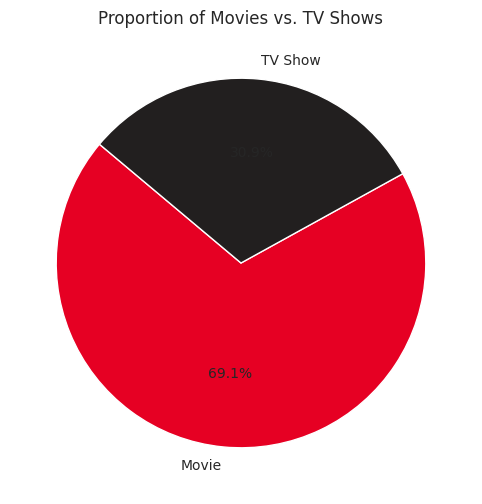

In [10]:
plt.figure(figsize=(8, 6))
type_counts = netflix_df['type'].value_counts()
plt.pie(type_counts, labels=type_counts.index, autopct='%1.1f%%', startangle=140, colors=['#e60023', '#221f1f'])
plt.title('Proportion of Movies vs. TV Shows')
plt.ylabel('')
plt.show()

<Figure size 1400x800 with 0 Axes>

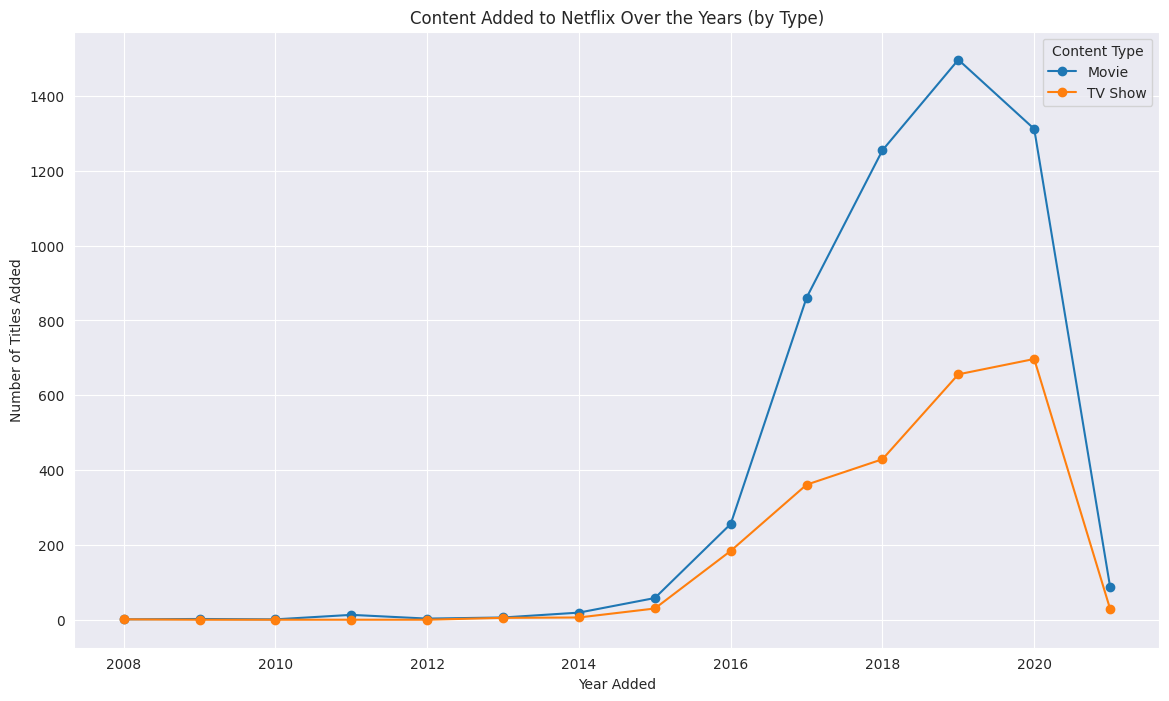

In [11]:
# Group data by year and content type
content_over_time = netflix_df.groupby(['year_added', 'type']).size().unstack().fillna(0)

plt.figure(figsize=(14, 8))
content_over_time.plot(kind='line', marker='o', figsize=(14, 8))
plt.title('Content Added to Netflix Over the Years (by Type)')
plt.xlabel('Year Added')
plt.ylabel('Number of Titles Added')
plt.legend(title='Content Type')
plt.grid(True)
plt.show()

In [12]:
netflix_df.head(2)

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,year_added,month_added
0,s1,TV Show,3%,Unknown,"João Miguel, Bianca Comparato, Michel Gomes, R...",Brazil,2020-08-14,2020,TV-MA,4 Seasons,"International TV Shows, TV Dramas, TV Sci-Fi &...",In a future where the elite inhabit an island ...,2020,8
1,s2,Movie,7:19,Jorge Michel Grau,"Demián Bichir, Héctor Bonilla, Oscar Serrano, ...",Mexico,2016-12-23,2016,TV-MA,93 min,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...,2016,12


In [14]:
# Split the 'listed_in' column and explode it
genres = netflix_df.assign(genre=netflix_df['listed_in'].str.split(', ')).explode('genre')

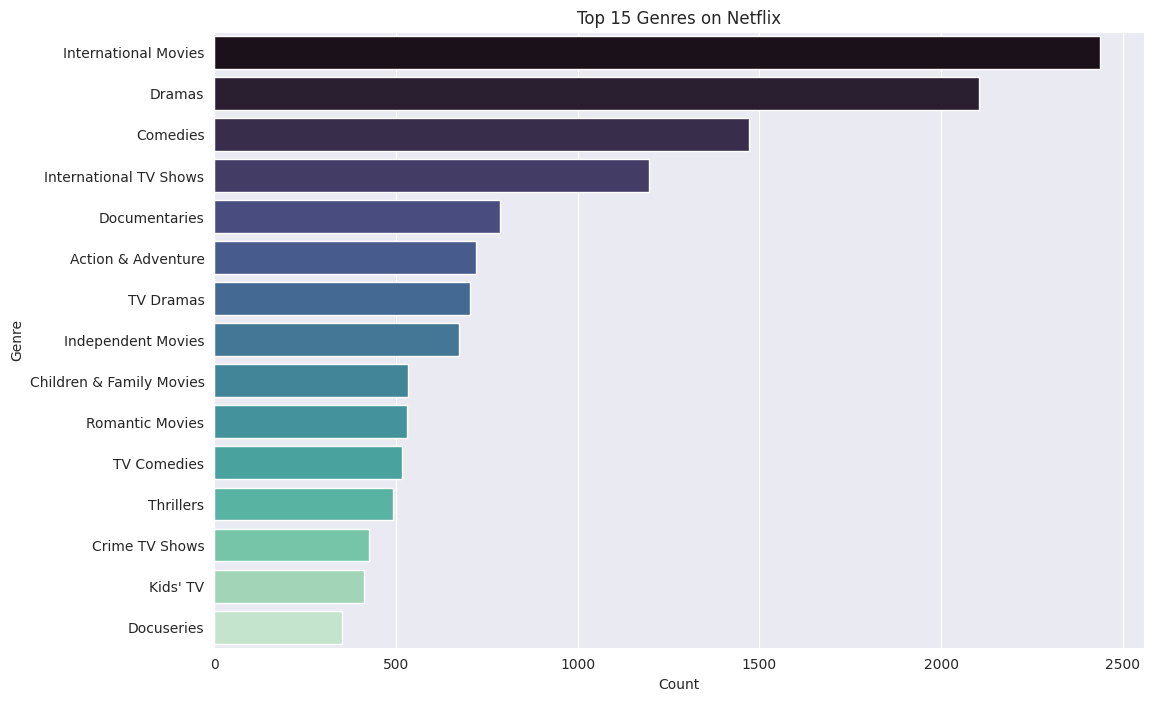

In [15]:
# Get the top 15 genres and their counts
top_genres_counts = genres['genre'].value_counts().reset_index()
top_genres_counts.columns = ['genre', 'count'] # Rename columns for clarity

# Select only the top 15 for plotting
top_genres_counts_plot = top_genres_counts.head(15)

plt.figure(figsize=(12, 8))
sns.barplot(y='genre', x='count', data=top_genres_counts_plot, palette='mako', hue='genre', legend=False)
plt.title('Top 15 Genres on Netflix')
plt.xlabel('Count')
plt.ylabel('Genre')
plt.show()

In [16]:
# Separate movies and TV shows
movies_df = netflix_df[netflix_df['type'] == 'Movie'].copy()
tv_shows_df = netflix_df[netflix_df['type'] == 'TV Show'].copy()

In [17]:
# Clean and convert duration for movies
movies_df['duration_min'] = movies_df['duration'].str.replace(' min', '').astype(int)

# Clean and convert duration for TV shows
tv_shows_df['seasons'] = tv_shows_df['duration'].str.replace(' Seasons', '').str.replace(' Season', '').astype(int)

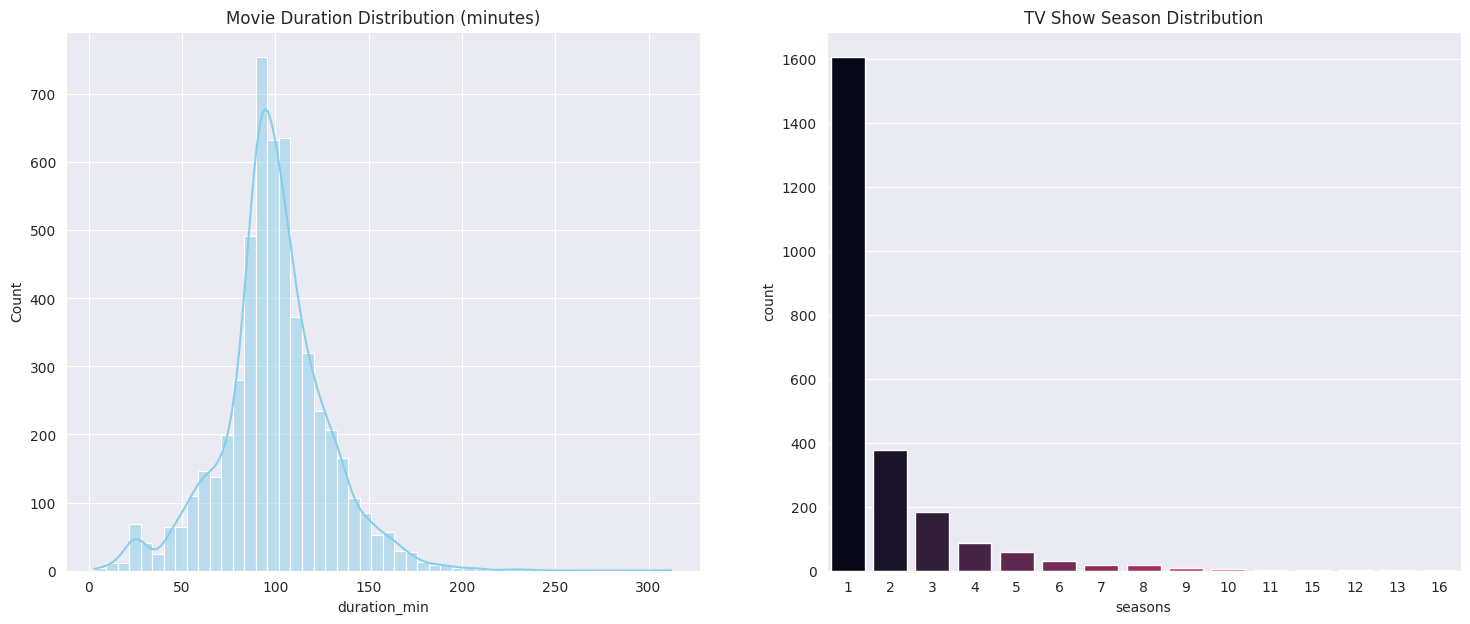

In [18]:
# Plot the distributions
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Movie Duration Distribution
sns.histplot(ax=axes[0], data=movies_df, x='duration_min', bins=50, kde=True, color='skyblue').set_title('Movie Duration Distribution (minutes)')

# TV Show Season Distribution
sns.countplot(ax=axes[1], x='seasons', data=tv_shows_df, palette='rocket', order=tv_shows_df['seasons'].value_counts().index, hue='seasons', legend=False).set_title('TV Show Season Distribution')

plt.show()

In [19]:
# Handle the multi-country listings similar to genres
countries = netflix_df.assign(country=netflix_df['country'].str.split(', ')).explode('country')

In [20]:
# Get the top 15 countries and their counts
top_countries_counts = countries['country'].value_counts().reset_index()
top_countries_counts.columns = ['country', 'count'] # Rename columns for clarity

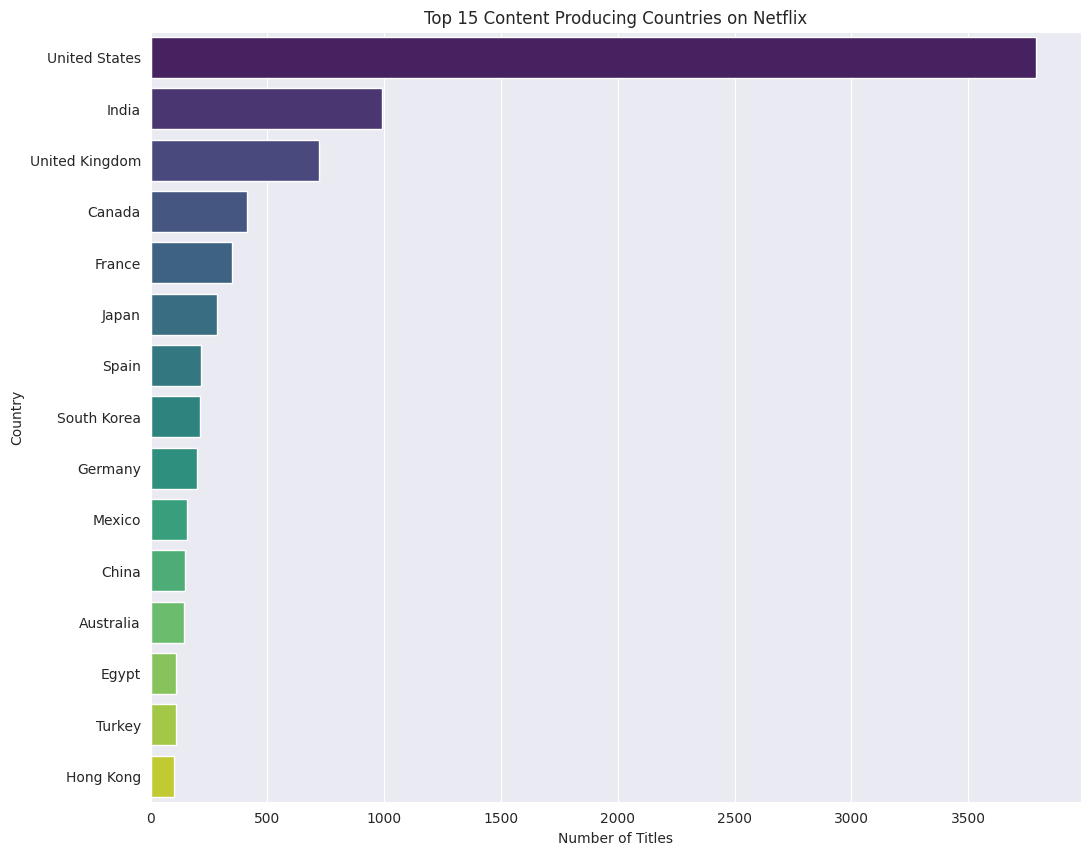

In [21]:
# Select only the top 15 for plotting
top_countries_counts_plot = top_countries_counts.head(15)

plt.figure(figsize=(12, 10))
sns.barplot(y='country', x='count', data=top_countries_counts_plot, palette='viridis', hue='country', legend=False)
plt.title('Top 15 Content Producing Countries on Netflix')
plt.xlabel('Number of Titles')
plt.ylabel('Country')
plt.show()

In [22]:
netflix_df.head(2)

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,year_added,month_added
0,s1,TV Show,3%,Unknown,"João Miguel, Bianca Comparato, Michel Gomes, R...",Brazil,2020-08-14,2020,TV-MA,4 Seasons,"International TV Shows, TV Dramas, TV Sci-Fi &...",In a future where the elite inhabit an island ...,2020,8
1,s2,Movie,7:19,Jorge Michel Grau,"Demián Bichir, Héctor Bonilla, Oscar Serrano, ...",Mexico,2016-12-23,2016,TV-MA,93 min,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...,2016,12


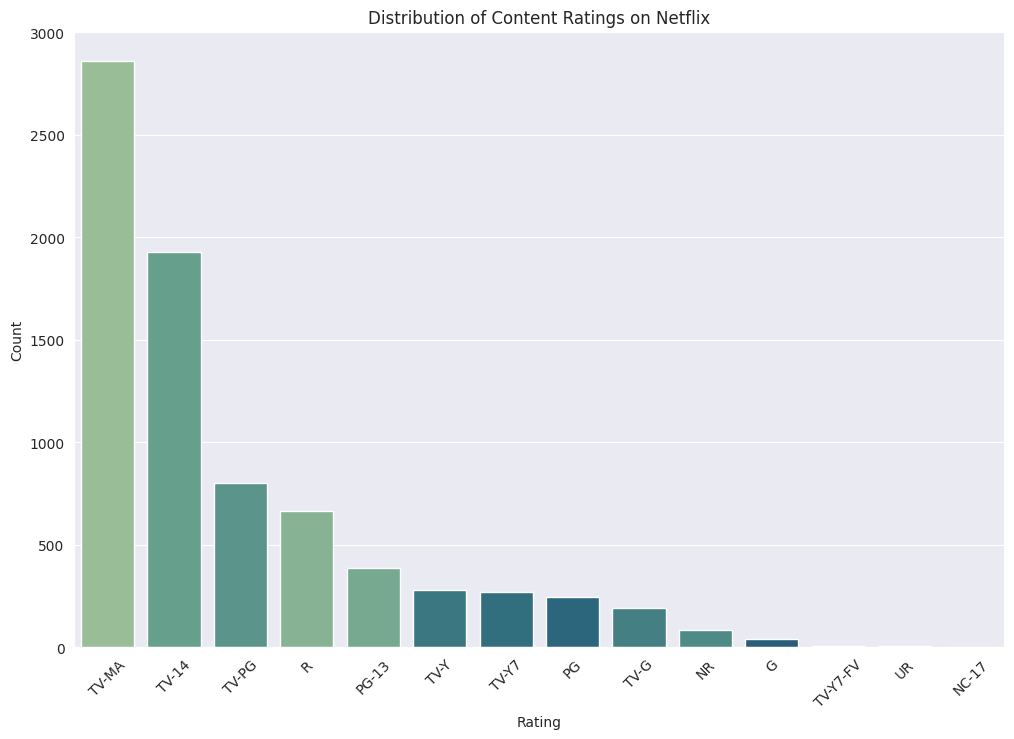

In [23]:
plt.figure(figsize=(12, 8))
sns.countplot(x='rating', data=netflix_df, order=netflix_df['rating'].value_counts().index, palette='crest', hue='rating', legend=False)
plt.title('Distribution of Content Ratings on Netflix')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

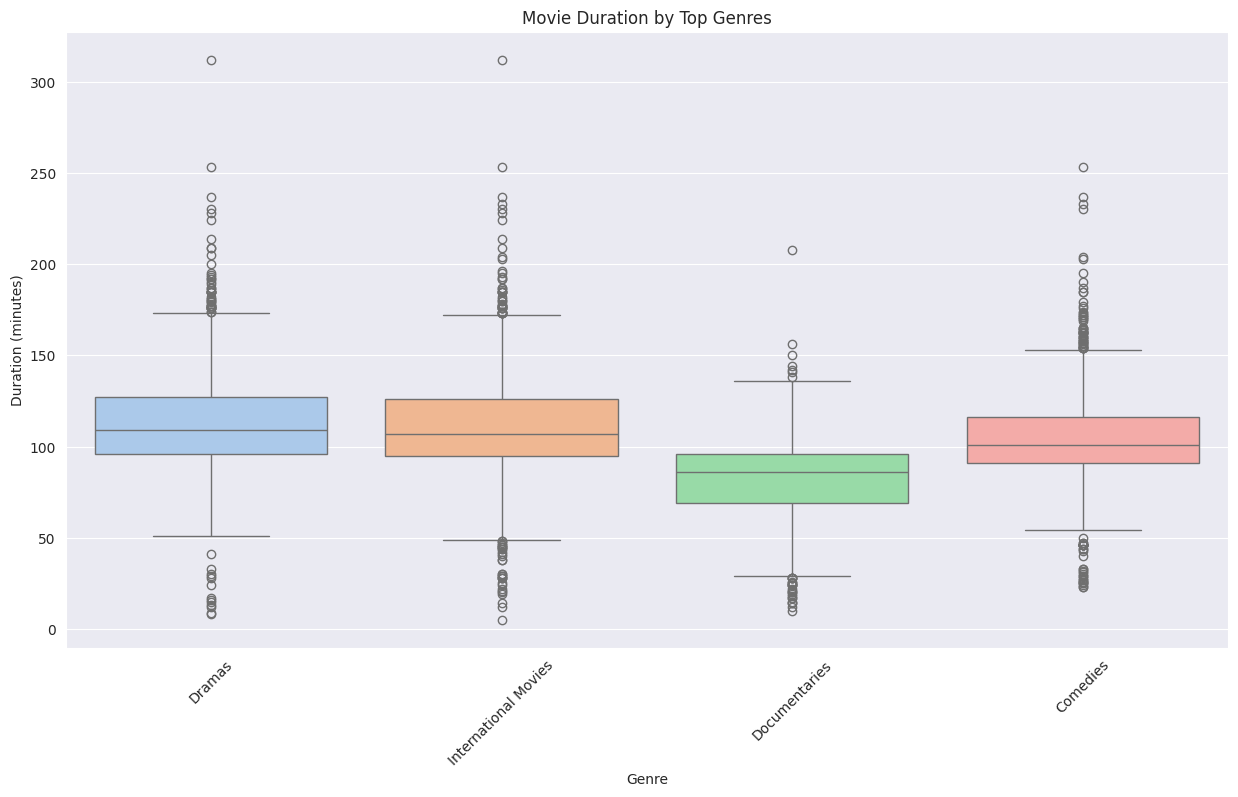

In [24]:
# Analyze movie duration across different top genres
top_genres = genres['genre'].value_counts().index[:5]
genres_movies = genres[(genres['type'] == 'Movie') & (genres['genre'].isin(top_genres))].copy()
genres_movies['duration_min'] = genres_movies['duration'].str.replace(' min', '').astype(int)

plt.figure(figsize=(15, 8))
sns.boxplot(data=genres_movies, x='genre', y='duration_min', palette='pastel', hue='genre', legend=False)
plt.title('Movie Duration by Top Genres')
plt.xlabel('Genre')
plt.ylabel('Duration (minutes)')
plt.xticks(rotation=45)
plt.show()

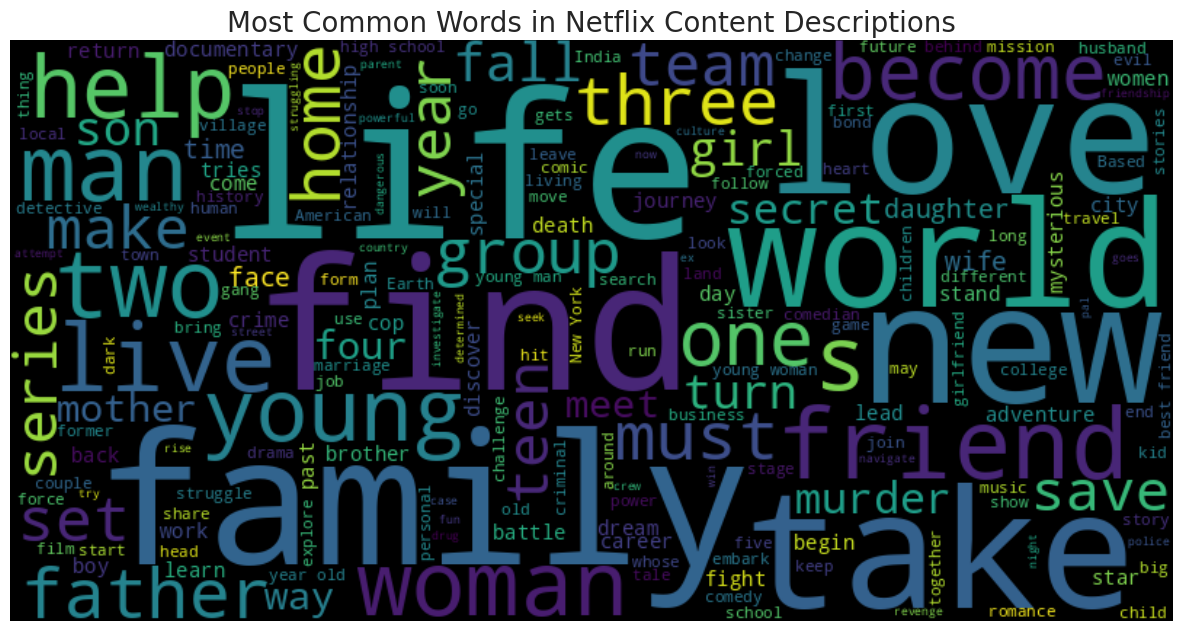

In [25]:
# Combine all descriptions into a single string
text = ' '.join(netflix_df['description'])

# Create and generate a word cloud image
wordcloud = WordCloud(width=800, height=400, background_color='black').generate(text)

# Display the generated image
plt.figure(figsize=(15, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Common Words in Netflix Content Descriptions', fontsize=20)
plt.show()